# Housekeeping Genes Prediction – Part 1
**GitHub:** https://github.com/pirsquareff/pattern-assignment-2

In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc
import random
import math

## Importing Data

In [130]:
data = pd.read_csv("./data/12864_2006_660_MOESM1_ESM.csv")

In [131]:
data.describe()

,cDNA_length,cds_length,exons_nr,perc_go_hk_match,perc_go_ts_match
count,35164.000000,35164.000000,20568.000000,25957.000000,25957.000000
mean,2439.950432,1484.058583,6.568748,0.036278,0.222914
std,2012.944961,1502.566846,8.333126,0.131669,0.253348
min,45.000000,45.000000,1.000000,0.000000,0.000000
25%,1168.000000,642.000000,1.000000,0.000000,0.000000
50%,2047.000000,1119.000000,3.000000,0.000000,0.166667
75%,3185.250000,1821.000000,9.000000,0.000000,0.363636
max,99631.000000,98385.000000,118.000000,1.000000,1.000000


In [132]:
data.head()

,EMBL_transcript_id,cDNA_length,cds_length,exons_nr,5_MAR_presence,3_MAR_presence,5_polyA_18_presence,5_CCGNN_2_5_presence,perc_go_hk_match,perc_go_ts_match,is_hk
0,ENST00000274311,2918.0,1158.0,3.0,no,no,no,yes,0.1,0.200000,NaN
1,ENST00000282588,4795.0,3540.0,29.0,no,no,no,yes,0.1,0.200000,NaN
2,ENST00000274311,2918.0,1158.0,3.0,no,no,no,yes,0.1,0.200000,NaN
3,ENST00000282588,4795.0,3540.0,29.0,no,no,no,yes,0.1,0.200000,NaN
4,ENST00000337416,4551.0,1656.0,18.0,no,yes,no,no,0.0,0.111111,NaN


## Cleaning Data

There are many missing values in this database. They are represented with NaN. In the previous homework, we filled the missing values with the mean, median, or mode values. That is because classifiers such as logistic regression cannot deal with missing feature values. However, for the case of Naive Bayes which we will use in this homework compares $\prod_{i} p(x_{i} | class)$ and treat each $x_{i}$ as independent features. Thus, if a feature $i$ is missing, we can drop that term from the comparison without having to guess what the missing feature is. First, convert the yes and no in this data table to 1 and 0. We can also drop the name of the genes and just refer to them by their index values.

In [133]:
data.loc[data["5_MAR_presence"] == "no", "5_MAR_presence"] = 0.0
data.loc[data["5_MAR_presence"] == "yes", "5_MAR_presence"] = 1.0
data.loc[data["3_MAR_presence"] == "no", "3_MAR_presence"] = 0.0
data.loc[data["3_MAR_presence"] == "yes", "3_MAR_presence"] = 1.0
data.loc[data["5_polyA_18_presence"] == "no", "5_polyA_18_presence"] = 0.0
data.loc[data["5_polyA_18_presence"] == "yes", "5_polyA_18_presence"] = 1.0
data.loc[data["5_CCGNN_2_5_presence"] == "no", "5_CCGNN_2_5_presence"] = 0.0
data.loc[data["5_CCGNN_2_5_presence"] == "yes", "5_CCGNN_2_5_presence"] = 1.0
data.loc[data["is_hk"] == "no", "is_hk"] = 0.0
data.loc[data["is_hk"] == "yes", "is_hk"] = 1.0
del data["EMBL_transcript_id"]

### How many items are `NaN` in the `is_hk` column?
There are 46459 items that are `NaN` in the `is_hk` column.

In [134]:
data_is_hk_nan = data[pd.isnull(data["is_hk"])]
n_is_hk_nan = len(data_is_hk_nan)
n_is_hk_nan

46459

### How many items are known housekeeping genes?
There are 103 items that are known housekeeping genes.

In [135]:
data_is_hk_yes = data[data["is_hk"] == 1.0]
n_is_hk_yes = len(data_is_hk_yes)
n_is_hk_yes

103

### How many items are known tissue specific genes?
There are 667 items that are known housekeeping genes.

In [136]:
data_is_hk_no = data[data["is_hk"] == 0.0]
n_is_hk_no = len(data_is_hk_no)
n_is_hk_no

667

## Splitting Data into Testing and Training Set
Select 10% of the `is_hk == yes` and 10% of the `is_hk == no` as your testing set, `test_set`. Then, use the rest of the data as your training set, `train_set`. From `train_set`, filter the ones with `is_hk == NaN` as the unsupervised training set, `unsup_train_set`. Filter the ones with `is_hk == yes` or `no` as the supervised training set, `sup_train_set`.

In [137]:
# Randomly sample 10% from is_hk_yes
data_10_percent_from_is_hk_yes = data_is_hk_yes.sample(frac = 0.1)
len(data_10_percent_from_is_hk_yes)

10

In [138]:
# Randomly sample 10% from is_hk_no
data_10_percent_from_is_hk_no = data_is_hk_no.sample(frac = 0.1)
len(data_10_percent_from_is_hk_no)

67

In [139]:
test_set = pd.concat([data_10_percent_from_is_hk_yes, data_10_percent_from_is_hk_no], ignore_index = False)
test_set.head()

,cDNA_length,cds_length,exons_nr,5_MAR_presence,3_MAR_presence,5_polyA_18_presence,5_CCGNN_2_5_presence,perc_go_hk_match,perc_go_ts_match,is_hk
11206,691.0,360.0,NaN,0,0,1,0,0.500000,0.0,1
8802,1233.0,600.0,NaN,0,0,0,0,0.000000,0.0,1
12779,3595.0,546.0,5.0,0,0,1,0,0.000000,0.0,1
9810,1151.0,747.0,NaN,0,0,0,0,0.200000,0.0,1
7205,1281.0,711.0,8.0,0,0,0,1,0.666667,0.0,1


In [140]:
train_set = data.loc[~data.index.isin(test_set.index)]
train_set.head()

,cDNA_length,cds_length,exons_nr,5_MAR_presence,3_MAR_presence,5_polyA_18_presence,5_CCGNN_2_5_presence,perc_go_hk_match,perc_go_ts_match,is_hk
0,2918.0,1158.0,3.0,0,0,0,1,0.1,0.200000,NaN
1,4795.0,3540.0,29.0,0,0,0,1,0.1,0.200000,NaN
2,2918.0,1158.0,3.0,0,0,0,1,0.1,0.200000,NaN
3,4795.0,3540.0,29.0,0,0,0,1,0.1,0.200000,NaN
4,4551.0,1656.0,18.0,0,1,0,0,0.0,0.111111,NaN


In [141]:
unsup_train_set = train_set[pd.isnull(train_set["is_hk"])]
unsup_train_set.head()

,cDNA_length,cds_length,exons_nr,5_MAR_presence,3_MAR_presence,5_polyA_18_presence,5_CCGNN_2_5_presence,perc_go_hk_match,perc_go_ts_match,is_hk
0,2918.0,1158.0,3.0,0,0,0,1,0.1,0.200000,NaN
1,4795.0,3540.0,29.0,0,0,0,1,0.1,0.200000,NaN
2,2918.0,1158.0,3.0,0,0,0,1,0.1,0.200000,NaN
3,4795.0,3540.0,29.0,0,0,0,1,0.1,0.200000,NaN
4,4551.0,1656.0,18.0,0,1,0,0,0.0,0.111111,NaN


In [142]:
sup_train_set = train_set.loc[~train_set.index.isin(unsup_train_set.index)]
sup_train_set.head()

,cDNA_length,cds_length,exons_nr,5_MAR_presence,3_MAR_presence,5_polyA_18_presence,5_CCGNN_2_5_presence,perc_go_hk_match,perc_go_ts_match,is_hk
91,3845.0,786.0,NaN,0,0,0,0,0.333333,0.0,1
92,960.0,960.0,NaN,0,0,0,0,0.333333,0.0,1
93,3492.0,786.0,NaN,0,0,0,0,0.333333,0.0,1
218,4019.0,3861.0,NaN,0,0,0,1,0.000000,0.5,0
220,3847.0,3840.0,NaN,0,0,0,1,0.000000,0.5,0


## Histogram Discretization
In class, we learned that in order to create a Bayes Classifier we first need to estimate the posterior or likelihood probability distributions. The simplest way to estimate probability distributions is via histograms. To do histogram estimation, we divide the entire data space into a finite number of bins. Then, we count how many data points are there in each bin and normalize using the total number of data points (so that the probability sums to 1). Since we are grouping a continuous valued feature into a finite number of bins, we can also call this process, discretization.

In [143]:
# remove NaN values
train_set_clength = train_set["cDNA_length"]
train_set_clength_no_nan = train_set_clength[~pd.isnull(train_set_clength)]
train_set_cdslength = train_set["cds_length"]
train_set_cdslength_no_nan = train_set_cdslength[~pd.isnull(train_set_cdslength)]
train_set_exons_nr = train_set["exons_nr"]
train_set_exons_nr_no_nan = train_set_exons_nr[~pd.isnull(train_set_exons_nr)]
train_set_perc_go_hk_match = train_set["perc_go_hk_match"]
train_set_perc_go_hk_match_no_nan = train_set_perc_go_hk_match[~pd.isnull(train_set_perc_go_hk_match)]
train_set_perc_go_ts_match = train_set["perc_go_ts_match"]
train_set_perc_go_ts_match_no_nan = train_set_perc_go_ts_match[~pd.isnull(train_set_perc_go_ts_match)]

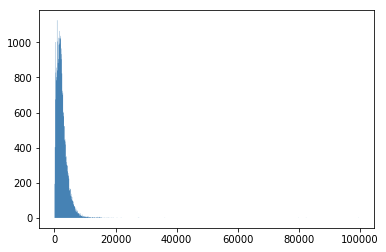

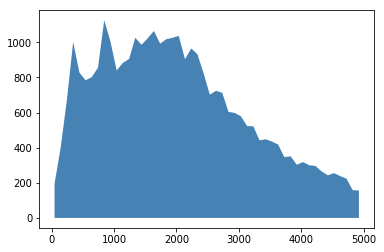

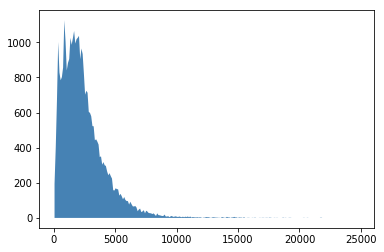

In [144]:
# bin the data into 1000 equally spaced bins
# hist is the count for each bin
# bin_edge is the edge values of the bins
hist, bin_edge = np.histogram(train_set_clength_no_nan, 1000)
# make sure to import matplotlib.pyplot as plt
# plot the histogram
plt.fill_between(bin_edge.repeat(2)[1:-1], hist.repeat(2), facecolor = 'steelblue')
plt.show()
# plot the first 100 bins only
plt.fill_between(bin_edge.repeat(2)[1:100], hist.repeat(2)[1:100], facecolor = 'steelblue')
plt.show()
# plot the first 500 bins only
plt.fill_between(bin_edge.repeat(2)[1:500], hist.repeat(2)[1:500], facecolor='steelblue')
plt.show()

### Observe the histograms. Can we use a Gaussian to estimate this histogram? Why? What about a Gaussian Mixture Model (GMM)?
No. Gaussian seems unfit to estimate this histogram. But we can use Gaussian Mixture Model (GMM) with an appropriate number of mixture instead, because GMM can actually fit any distribution.

### How many bins have zero counts? Do you think this is a good discretization? Why?
There are 823 bins with zero counts.

In [145]:
len(np.where(hist == 0)[0])

823

## Segment to the Density of the Data Points.
1) Sort the data points into a ranked list, `train_set_clength_no_nan_sorted`. <br>
2) Define the bin edge at equally spaced ranks. You can do so by `train_set_clength_no_nan_sorted[0::spacing]`. <br>
3) If we do it this way, each values in bin edge is not necessary unique. We can remove duplicate values by `bin_edge = np.unique(bin_edge)` <br>
4) We can then bin each values in the training set into bins using the function `np.digitize`, then count the number in each bins using `np.bincount`.

### cDNA_length

In [146]:
train_set_clength_no_nan_sorted = train_set_clength_no_nan.sort_values(inplace = False)

In [147]:
clength_spacing = 35
clength_bin_edge = train_set_clength_no_nan_sorted[0::clength_spacing]
clength_bin_edge = np.unique(clength_bin_edge)
print(len(clength_bin_edge))

998


In [148]:
clength_digitized = np.digitize(train_set_clength_no_nan_sorted, clength_bin_edge)
clength_digitized

array([  1,   1,   1, ..., 998, 998, 998])

In [149]:
clength_bincount = np.bincount(clength_digitized)
clength_bincount = clength_bincount[1:]
print(len(clength_bincount))

998


In [150]:
clength_bin_edge = np.append(clength_bin_edge, clength_bin_edge[-1])

### Plot the histogram according to our new discretization scheme just like the process above (with ∼1000 bins, and show 3 plots). Does it come out like how it should be?

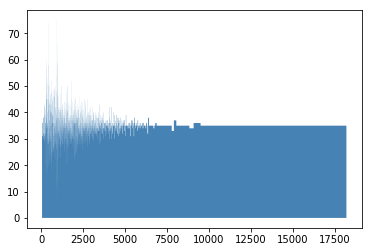

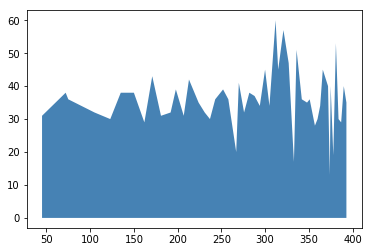

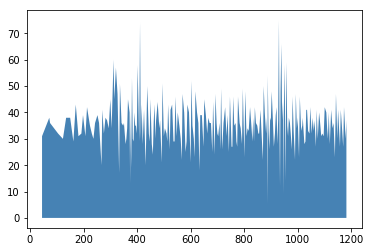

In [151]:
# plot the histogram
plt.fill_between(clength_bin_edge.repeat(2)[1:-1], clength_bincount.repeat(2), facecolor = 'steelblue')
plt.show()
# plot the first 100 bins only
plt.fill_between(clength_bin_edge.repeat(2)[1:100], clength_bincount.repeat(2)[1:100], facecolor = 'steelblue')
plt.show()
# plot the first 500 bins only
plt.fill_between(clength_bin_edge.repeat(2)[1:500], clength_bincount.repeat(2)[1:500], facecolor='steelblue')
plt.show()

### cds_length

In [152]:
train_set_cdslength_no_nan_sorted = train_set_cdslength_no_nan.sort_values(inplace = False)

In [153]:
cdslength_spacing = 20
cdslength_bin_edge = train_set_cdslength_no_nan_sorted[0::cdslength_spacing]
cdslength_bin_edge = np.unique(cdslength_bin_edge)
print(len(cdslength_bin_edge))

1000


In [154]:
cdslength_digitized = np.digitize(train_set_cdslength_no_nan_sorted, cdslength_bin_edge)
cdslength_digitized

array([   1,    1,    1, ..., 1000, 1000, 1000])

In [155]:
cdslength_bincount = np.bincount(cdslength_digitized)
cdslength_bincount = cdslength_bincount[1:]
print(len(cdslength_bincount))

1000


In [156]:
cdslength_bin_edge = np.append(cdslength_bin_edge, cdslength_bin_edge[-1])

### Plot the histogram according to our new discretization scheme just like the process above (with ∼1000 bins, and show 3 plots). Does it come out like how it should be?

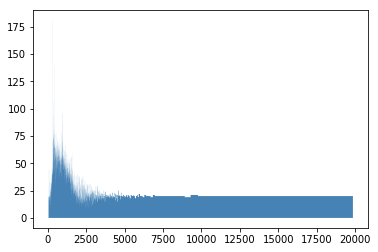

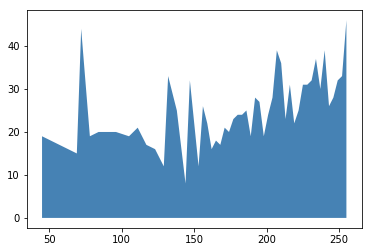

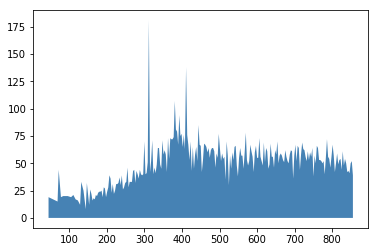

In [157]:
# plot the histogram
plt.fill_between(cdslength_bin_edge.repeat(2)[1:-1], cdslength_bincount.repeat(2), facecolor = 'steelblue')
plt.show()
# plot the first 100 bins only
plt.fill_between(cdslength_bin_edge.repeat(2)[1:100], cdslength_bincount.repeat(2)[1:100], facecolor = 'steelblue')
plt.show()
# plot the first 500 bins only
plt.fill_between(cdslength_bin_edge.repeat(2)[1:500], cdslength_bincount.repeat(2)[1:500], facecolor='steelblue')
plt.show()

### exons_nr

In [158]:
train_set_exons_nr_no_nan_sorted = train_set_exons_nr_no_nan.sort_values(inplace = False)

In [159]:
exons_nr_spacing = 1
exons_nr_bin_edge = train_set_exons_nr_no_nan_sorted[0::exons_nr_spacing]
exons_nr_bin_edge = np.unique(exons_nr_bin_edge)
print(len(exons_nr_bin_edge))

84


In [160]:
exons_nr_digitized = np.digitize(train_set_exons_nr_no_nan_sorted, exons_nr_bin_edge)
exons_nr_digitized

array([ 1,  1,  1, ..., 82, 83, 84])

In [161]:
exons_nr_bin_edge = np.append(exons_nr_bin_edge, exons_nr_bin_edge[-1])

### perc_go_ts_match

In [162]:
train_set_perc_go_hk_match_no_nan_sorted = train_set_perc_go_hk_match_no_nan.sort_values(inplace = False)

In [163]:
perc_go_hk_match_spacing = 1
perc_go_hk_match_bin_edge = train_set_perc_go_hk_match_no_nan_sorted[0::perc_go_hk_match_spacing]
perc_go_hk_match_bin_edge = np.unique(perc_go_hk_match_bin_edge)
print(len(perc_go_hk_match_bin_edge))

59


In [164]:
perc_go_hk_match_digitized = np.digitize(train_set_perc_go_hk_match_no_nan_sorted, perc_go_hk_match_bin_edge)
perc_go_hk_match_digitized

array([ 1,  1,  1, ..., 59, 59, 59])

In [165]:
perc_go_hk_match_bin_edge = np.append(perc_go_hk_match_bin_edge, perc_go_hk_match_bin_edge[-1])

### perc_go_ts_match

In [166]:
train_set_perc_go_ts_match_no_nan_sorted = train_set_perc_go_ts_match_no_nan.sort_values(inplace = False)

In [167]:
perc_go_ts_match_spacing = 1
perc_go_ts_match_bin_edge = train_set_perc_go_ts_match_no_nan_sorted[0::perc_go_ts_match_spacing]
perc_go_ts_match_bin_edge = np.unique(perc_go_ts_match_bin_edge)
print(len(perc_go_ts_match_bin_edge))

117


In [168]:
perc_go_ts_match_digitized = np.digitize(train_set_perc_go_ts_match_no_nan_sorted, perc_go_ts_match_bin_edge)
perc_go_ts_match_digitized

array([  1,   1,   1, ..., 117, 117, 117])

In [169]:
perc_go_ts_match_bin_edge = np.append(perc_go_ts_match_bin_edge, perc_go_ts_match_bin_edge[-1])

### Discretize the values of `cDNA_length` and `cds_length` according to the `train set`. In other words, figure out the bin edge for each feature, then use `digitize()` to convert the features to discrete values.

In [170]:
clength_digitized_df = pd.DataFrame(clength_digitized, index = train_set_clength_no_nan_sorted.index, columns = ["clength_digitized"])
cdslength_digitized_df = pd.DataFrame(cdslength_digitized, index = train_set_cdslength_no_nan_sorted.index, columns = ["cdslength_digitized"])
exons_nr_digitized_df = pd.DataFrame(exons_nr_digitized, index = train_set_exons_nr_no_nan_sorted.index, columns = ["exons_nr_digitized"])
perc_go_hk_match_digitized_df = pd.DataFrame(perc_go_hk_match_digitized, index = train_set_perc_go_hk_match_no_nan_sorted.index, columns = ["perc_go_hk_match_digitized"])
perc_go_ts_match_digitized_df = pd.DataFrame(perc_go_ts_match_digitized, index = train_set_perc_go_ts_match_no_nan_sorted.index, columns = ["perc_go_ts_match_digitized"])

In [171]:
train_set_digitized = train_set.join(clength_digitized_df).join(cdslength_digitized_df).join(exons_nr_digitized_df).join(perc_go_hk_match_digitized_df).join(perc_go_ts_match_digitized_df)
sup_train_set_digitized = sup_train_set.join(clength_digitized_df).join(cdslength_digitized_df).join(exons_nr_digitized_df).join(perc_go_hk_match_digitized_df).join(perc_go_ts_match_digitized_df)
unsup_train_set_digitize = unsup_train_set.join(clength_digitized_df).join(cdslength_digitized_df).join(exons_nr_digitized_df).join(perc_go_hk_match_digitized_df).join(perc_go_ts_match_digitized_df)

## The MLE for the likelihood distribution of discretized histograms
We would like to build a Naive Bayes classifier which compares the posterior $p(housekeeping | x_{i})$ against $p(nothousekeeping | x_{i})$. However, figuring out p(class|xi) is often hard (not true for this case). Thus, we turn to the likelihood $p(x_{i} | class)$, which can be derived from the discretized histograms.

### What is the MLE for the likelihood distributions of each of the 9 features? Plot the likelihood distributions. You should learn the discretization using `train_set`, but estimate the MLE using the `sup_train_set`.

In [172]:
n_is_hk_yes_in_sup_train_set = len(sup_train_set_digitized[sup_train_set_digitized["is_hk"] == 1.0])
print(n_is_hk_yes_in_sup_train_set)
n_is_hk_no_in_sup_train_set = len(sup_train_set_digitized[sup_train_set_digitized["is_hk"] == 0.0])
print(n_is_hk_no_in_sup_train_set)

93
600


In [173]:
sup_train_set_digitized.describe()

,cDNA_length,cds_length,exons_nr,perc_go_hk_match,perc_go_ts_match,clength_digitized,cdslength_digitized,exons_nr_digitized,perc_go_hk_match_digitized,perc_go_ts_match_digitized
count,693.000000,693.000000,192.000000,684.000000,684.000000,693.000000,693.000000,192.000000,684.000000,684.000000
mean,2389.643579,1531.770563,10.239583,0.057609,0.492486,500.966811,410.518038,10.239583,6.097953,70.527778
std,1726.420171,1451.403168,6.806595,0.183856,0.278978,254.269719,242.451345,6.806595,14.558834,37.293904
min,276.000000,135.000000,1.000000,0.000000,0.000000,23.000000,12.000000,1.000000,1.000000,1.000000
25%,1404.000000,750.000000,6.000000,0.000000,0.333333,308.000000,215.000000,6.000000,1.000000,53.000000
50%,2097.000000,1248.000000,9.000000,0.000000,0.600000,512.000000,381.000000,9.000000,1.000000,88.000000
75%,2871.000000,1698.000000,13.000000,0.000000,0.666667,694.000000,531.000000,13.000000,1.000000,95.000000
max,15365.000000,15123.000000,38.000000,1.000000,1.000000,997.000000,999.000000,38.000000,59.000000,117.000000


In [174]:
def mle_multinomial(df, col_name, label_name, n_label_yes, n_label_no, unsup_df, minl):
    col = df[[col_name, label_name]]
    col_no_nan = col[~pd.isnull(col[col_name])]
    col_is_hk_yes = col_no_nan[col_no_nan[label_name] == 1.0][col_name].astype(int)
    col_is_hk_no = col_no_nan[col_no_nan[label_name] == 0.0][col_name].astype(int)
    
    col_unsup_no_nan = unsup_df[~pd.isnull(unsup_df[col_name])][col_name].astype(int)
    alpha_and_beta = np.bincount(col_unsup_no_nan, minlength = minl)
    alpha = 0.005 * alpha_and_beta

    col_no_nan_likelihood_yes = (np.bincount(col_is_hk_yes, minlength = minl) + alpha) / (n_label_yes + alpha_and_beta)
    col_no_nan_likelihood_no = (np.bincount(col_is_hk_no, minlength = minl) + alpha) / (n_label_no + alpha_and_beta)

    col_no_nan_likelihood_yes[col_no_nan_likelihood_yes <= 0] = 0.000000001
    col_no_nan_likelihood_no[col_no_nan_likelihood_no <= 0] = 0.000000001
    
    print("Likelihood Distribution p({0:s} | {1:s})".format(col_name, label_name))
    print("Red: {0:s} = no, Green: {0:s} = yes".format(label_name))
    plt.bar(range(len(col_no_nan_likelihood_yes)), col_no_nan_likelihood_yes, 4, color = "green", alpha = 0.35)
    plt.bar(range(len(col_no_nan_likelihood_no)), col_no_nan_likelihood_no, 4, color = "red", alpha = 0.35)
    plt.show()
    return (lambda p: col_no_nan_likelihood_yes[p]), (lambda p: col_no_nan_likelihood_no[p])

### `cDNA_length` MLE

Likelihood Distribution p(clength_digitized | is_hk)
Red: is_hk = no, Green: is_hk = yes


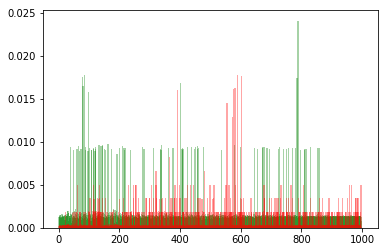

In [175]:
p_cDNA_length_given_hk, p_cDNA_length_given_not_hk = mle_multinomial(sup_train_set_digitized, "clength_digitized", "is_hk", n_is_hk_yes_in_sup_train_set, n_is_hk_no_in_sup_train_set, unsup_train_set_digitize, len(clength_bin_edge) + 1)

### `cds_length` MLE

Likelihood Distribution p(cdslength_digitized | is_hk)
Red: is_hk = no, Green: is_hk = yes


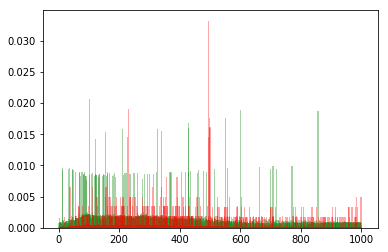

In [176]:
p_cds_length_given_hk, p_cds_length_given_not_hk = mle_multinomial(sup_train_set_digitized, "cdslength_digitized", "is_hk", n_is_hk_yes_in_sup_train_set, n_is_hk_no_in_sup_train_set, unsup_train_set_digitize, len(cdslength_bin_edge) + 1)

### `exons_nr` MLE

Likelihood Distribution p(exons_nr_digitized | is_hk)
Red: is_hk = no, Green: is_hk = yes


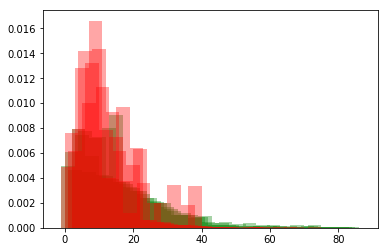

In [177]:
p_exons_nr_given_hk, p_exons_nr_given_not_hk = mle_multinomial(sup_train_set_digitized, "exons_nr_digitized", "is_hk", n_is_hk_yes_in_sup_train_set, n_is_hk_no_in_sup_train_set, unsup_train_set_digitize, len(exons_nr_bin_edge) + 1)

### `5_MAR_presence` MLE

Likelihood Distribution p(5_MAR_presence | is_hk)
Red: is_hk = no, Green: is_hk = yes


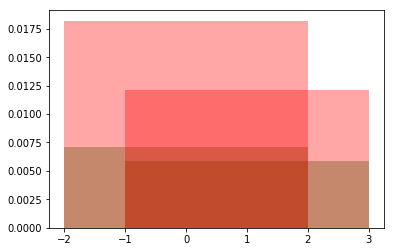

In [178]:
p_5_MAR_presence_given_hk, p_5_MAR_presence_given_not_hk = mle_multinomial(sup_train_set_digitized, "5_MAR_presence", "is_hk", n_is_hk_yes_in_sup_train_set, n_is_hk_no_in_sup_train_set, unsup_train_set_digitize, 2)

### `3_MAR_presence` MLE

Likelihood Distribution p(3_MAR_presence | is_hk)
Red: is_hk = no, Green: is_hk = yes


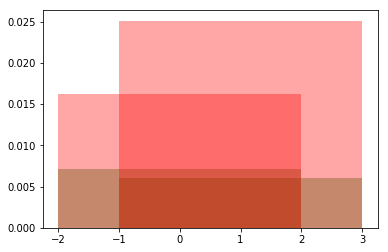

In [179]:
p_3_MAR_presence_given_hk, p_3_MAR_presence_given_not_hk = mle_multinomial(sup_train_set_digitized, "3_MAR_presence", "is_hk", n_is_hk_yes_in_sup_train_set, n_is_hk_no_in_sup_train_set, unsup_train_set_digitize, 2)

### `5_polyA_18_presence` MLE

Likelihood Distribution p(5_polyA_18_presence | is_hk)
Red: is_hk = no, Green: is_hk = yes


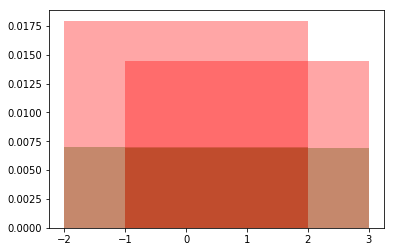

In [180]:
p_5_polyA_18_presence_given_hk, p_5_polyA_18_presence_given_not_hk = mle_multinomial(sup_train_set_digitized, "5_polyA_18_presence", "is_hk", n_is_hk_yes_in_sup_train_set, n_is_hk_no_in_sup_train_set, unsup_train_set_digitize, 2)

### `5_CCGNN_2_5_presence` MLE

Likelihood Distribution p(5_CCGNN_2_5_presence | is_hk)
Red: is_hk = no, Green: is_hk = yes


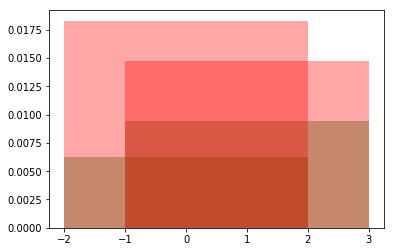

In [181]:
p_5_CCGNN_2_5_presence_given_hk, p_5_CCGNN_2_5_presence_given_not_hk = mle_multinomial(sup_train_set_digitized, "5_CCGNN_2_5_presence", "is_hk", n_is_hk_yes_in_sup_train_set, n_is_hk_no_in_sup_train_set, unsup_train_set_digitize, 2)

### `perc_go_hk_match` MLE

Likelihood Distribution p(perc_go_hk_match_digitized | is_hk)
Red: is_hk = no, Green: is_hk = yes


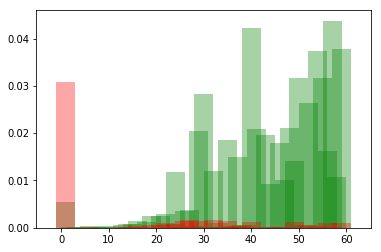

In [182]:
p_perc_go_hk_match_given_hk, p_perc_go_hk_match_given_not_hk = mle_multinomial(sup_train_set_digitized, "perc_go_hk_match_digitized", "is_hk", n_is_hk_yes_in_sup_train_set, n_is_hk_no_in_sup_train_set, unsup_train_set_digitize, len(perc_go_hk_match_bin_edge) + 1)

### `perc_go_ts_match` MLE

Likelihood Distribution p(perc_go_ts_match_digitized | is_hk)
Red: is_hk = no, Green: is_hk = yes


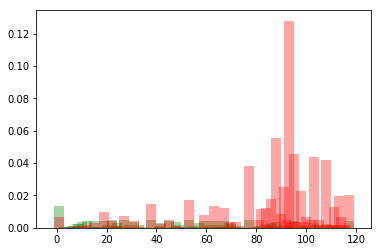

In [183]:
p_perc_go_ts_match_given_hk, p_perc_go_ts_match_given_not_hk = mle_multinomial(sup_train_set_digitized, "perc_go_ts_match_digitized", "is_hk", n_is_hk_yes_in_sup_train_set, n_is_hk_no_in_sup_train_set, unsup_train_set_digitize, len(perc_go_ts_match_bin_edge) + 1)

### What is the prior distribution of the two classes?
Bernoulli distribution.

In [184]:
p_hk = n_is_hk_yes_in_sup_train_set / len(sup_train_set_digitized)
print("p(is_hk = yes): {0:f}".format(p_hk))
p_not_hk = n_is_hk_no_in_sup_train_set / len(sup_train_set_digitized)
print("p(is_hk = no): {0:f}".format(p_not_hk))

p(is_hk = yes): 0.134199
p(is_hk = no): 0.865801


## Naive Bayes classification
We are now ready to build our Naive Bayes classifier. Which makes a decision according to

$$H(x) = \frac{p(housekeeping)}{p(nothousekeeping)}\prod_{i=1}\frac{p(x_{i}|housekeeping)}{p(x_{i}|nothousekeeping)}$$

If $H(x)$ is larger than 1, then classify it as housekeeping. If $H(x)$ is smaller than 1, then classify it as not housekeeping.<br>
Note we often work in the log scale to prevent floating point underflow. In other words,

$$lH(x) = logp(housekeeping)−logp(nothousekeeping)+ \sum_{i=1}[logp(x_{i}|housekeeping)−logp(x_{i}|nothousekeeping)]$$

If $lH(x)$ is larger than 0, then classify it as housekeeping. If $lH(x)$ is smaller than 0, then classify it as not housekeeping.

Use the learned distributions to classify the test set. Don’t forget to allow your classifier to handle missing values in the test set. Report the overall Accuracy. Then, report the Precision, Recall, and F score for detecting housekeeping gene. See Lecture 1 for the definitions of each metric.

In [185]:
def naive_bayes_classifier(row, y_score = False, threshold = 0):
    features_likelihood = np.array([0] * 9)
    if(~pd.isnull(row["cDNA_length"])):
        x = np.digitize([row["cDNA_length"]], clength_bin_edge)[0]
        features_likelihood[0] = math.log(p_cDNA_length_given_hk(x)) - math.log(p_cDNA_length_given_not_hk(x))
    if(~pd.isnull(row["cds_length"])):
        x = np.digitize([row["cds_length"]], cdslength_bin_edge)[0]
        features_likelihood[1] = math.log(p_cds_length_given_hk(x)) - math.log(p_cds_length_given_not_hk(x))
    if(~pd.isnull(row["exons_nr"])):
        x = np.digitize([row["exons_nr"]], exons_nr_bin_edge)[0]
        features_likelihood[2] = math.log(p_exons_nr_given_hk(x)) - math.log(p_exons_nr_given_not_hk(x))
    if(~pd.isnull(row["5_MAR_presence"])):
        x = int(row["5_MAR_presence"])
        features_likelihood[3] = math.log(p_5_MAR_presence_given_hk(x)) - math.log(p_5_MAR_presence_given_not_hk(x))
    if(~pd.isnull(row["3_MAR_presence"])):
        x =  int(row["3_MAR_presence"])
        features_likelihood[4] = math.log(p_3_MAR_presence_given_hk(x)) - math.log(p_3_MAR_presence_given_not_hk(x))
    if(~pd.isnull(row["5_polyA_18_presence"])):
        x =  int(row["5_polyA_18_presence"])
        features_likelihood[5] = math.log(p_5_polyA_18_presence_given_hk(x)) - math.log(p_5_polyA_18_presence_given_not_hk(x))
    if(~pd.isnull(row["5_CCGNN_2_5_presence"])):
        x =  int(row["5_CCGNN_2_5_presence"])
        features_likelihood[6] = math.log(p_5_CCGNN_2_5_presence_given_hk(x)) - math.log(p_5_CCGNN_2_5_presence_given_not_hk(x))
    if(~pd.isnull(row["perc_go_hk_match"])):
        x = np.digitize([row["perc_go_hk_match"]], perc_go_hk_match_bin_edge)[0]
        features_likelihood[7] = math.log(p_perc_go_hk_match_given_hk(x)) - math.log(p_perc_go_hk_match_given_not_hk(x))
    if(~pd.isnull(row["perc_go_ts_match"])):
        x = np.digitize([row["perc_go_ts_match"]], perc_go_ts_match_bin_edge)[0]
        features_likelihood[8] = math.log(p_perc_go_ts_match_given_hk(x)) - math.log(p_perc_go_ts_match_given_not_hk(x))
    l_hx = math.log(p_hk) - math.log(p_not_hk)
    for i in range(9):
        l_hx += features_likelihood[i]
    if(y_score): 
        return l_hx
    return 1 if l_hx > threshold else 0

In [186]:
def evaluate(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred, normalize = True)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return acc, precision, recall, f1

In [187]:
result = test_set.apply(lambda row: naive_bayes_classifier(row), axis = 1)

In [188]:
result.acc, result.precision, result.recall, result.f1 = evaluate(test_set["is_hk"].values.astype(int), result.values.astype(int))
print("Accuracy: {0:f}\nPrecision: {1:f}\nRecall: {2:f}\nF1: {3:f}".format(result.acc, result.precision, result.recall, result.f1))

Accuracy: 0.961039
Precision: 1.000000
Recall: 0.700000
F1: 0.823529


## Baseline comparison
In machine learning, we need to be able to evaluate how good our model is. We usually compare our model with a different model and show that our model is better. Sometimes we do not have a candidate model to evaluate our method against. In this homework, we will look at two simple baselines, the random choice, and the majority rule.

The random choice baseline is the accuracy if you make a random guess for each test sample. Give random guess (50% being housekeeping, and 50% being not housekeeping) to the test samples. Report the overall Accuracy. Then, report the Precision, Recall, and F score for detecting housekeeping gene using the random choice baseline.

The majority rule is the accuracy if you use the most frequent class from the training set as the classification decision. Report the overall Accuracy. Then, report the Precision, Recall, and F score for detecting housekeeping gene using the majority rule baseline.

### Random Choice Baseline

In [189]:
def random_choice_baseline_classifier(row):
    return random.randint(0, 1)

In [190]:
result_random_choice_baseline = test_set.apply(lambda row: random_choice_baseline_classifier(row), axis = 1)

In [191]:
result_random_choice_baseline.acc, result_random_choice_baseline.precision, result_random_choice_baseline.recall, result_random_choice_baseline.f1 = evaluate(test_set["is_hk"].values.astype(int), result_random_choice_baseline.values.astype(int))
print("Accuracy: {0:f}\nPrecision: {1:f}\nRecall: {2:f}\nF1: {3:f}".format(result_random_choice_baseline.acc, result_random_choice_baseline.precision, result_random_choice_baseline.recall, result_random_choice_baseline.f1))

Accuracy: 0.506494
Precision: 0.166667
Recall: 0.700000
F1: 0.269231


### Majority Rule Baseline

In [192]:
u, indices = np.unique(sup_train_set["is_hk"].values.astype(int), return_inverse = True)
majority = int(u[np.argmax(np.bincount(indices))])
def majority_rule_baseline_classifier(row):
    return majority

In [193]:
result_majority_rule_baseline = test_set.apply(lambda row: majority_rule_baseline_classifier(row), axis = 1)

In [194]:
result_majority_rule_baseline.values.astype(int)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [195]:
result_majority_rule_baseline.acc, result_majority_rule_baseline.precision, result_majority_rule_baseline.recall, result_majority_rule_baseline.f1 = evaluate(test_set["is_hk"].values.astype(int), result_majority_rule_baseline.values.astype(int))
print("Accuracy: {0:f}\nPrecision: {1:f}\nRecall: {2:f}\nF1: {3:f}".format(result_majority_rule_baseline.acc, result_majority_rule_baseline.precision, result_majority_rule_baseline.recall, result_majority_rule_baseline.f1))

Accuracy: 0.870130
Precision: 0.000000
Recall: 0.000000
F1: 0.000000


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


### Compare the two baselines with your Naive Bayes classifier.
Comparing with the random choice and the majority rule baseline, naive bayes classifier can perform better as gaining higher score in accuracy, precision, recall and F1.

## Threshold Finding
In practice, instead of comparing $lH(x)$ against $0$, we usually compare against a threshold, $t$. We can change the threshold so that we maximize the accuracy, precision, recall, or F score (depending on which measure we want to optimize).

- Use the following threshold values, $t = np.arange(-5, 5, 0.05)$

### Find the best accuracy, and F score (and the corresponding thresholds)
The best accuracy is 0.961039 and f1 score is 0.823529 with the corresponding thresholds from -1.85 to 0.1 

In [196]:
ts_acc = []
ts_precision = []
ts_recall = []
ts_f1 = []
for t in np.arange(-5, 5, 0.05):
    result = test_set.apply(lambda row: naive_bayes_classifier(row, threshold = t), axis = 1)
    print("Threshold: {0:.2f}".format(t))
    acc, precision, recall, f1 = evaluate(test_set["is_hk"].values.astype(int), result.values.astype(int))
    ts_acc.append(acc)
    ts_precision.append(precision)
    ts_recall.append(recall)
    ts_f1.append(f1)
    print("Accuracy: {0:f}\nPrecision: {1:f}\nRecall: {2:f}\nF1: {3:f}\n".format(acc, precision, recall, f1))

Threshold: -5.00
Accuracy: 0.467532
Precision: 0.196078
Recall: 1.000000
F1: 0.327869

Threshold: -4.95
Accuracy: 0.467532
Precision: 0.196078
Recall: 1.000000
F1: 0.327869

Threshold: -4.90
Accuracy: 0.467532
Precision: 0.196078
Recall: 1.000000
F1: 0.327869

Threshold: -4.85
Accuracy: 0.675325
Precision: 0.285714
Recall: 1.000000
F1: 0.444444

Threshold: -4.80
Accuracy: 0.675325
Precision: 0.285714
Recall: 1.000000
F1: 0.444444

Threshold: -4.75
Accuracy: 0.675325
Precision: 0.285714
Recall: 1.000000
F1: 0.444444

Threshold: -4.70
Accuracy: 0.675325
Precision: 0.285714
Recall: 1.000000
F1: 0.444444

Threshold: -4.65
Accuracy: 0.675325
Precision: 0.285714
Recall: 1.000000
F1: 0.444444

Threshold: -4.60
Accuracy: 0.675325
Precision: 0.285714
Recall: 1.000000
F1: 0.444444

Threshold: -4.55
Accuracy: 0.675325
Precision: 0.285714
Recall: 1.000000
F1: 0.444444

Threshold: -4.50
Accuracy: 0.675325
Precision: 0.285714
Recall: 1.000000
F1: 0.444444

Threshold: -4.45
Accuracy: 0.675325
Precisi


Threshold: -0.10
Accuracy: 0.961039
Precision: 1.000000
Recall: 0.700000
F1: 0.823529

Threshold: -0.05
Accuracy: 0.961039
Precision: 1.000000
Recall: 0.700000
F1: 0.823529

Threshold: -0.00
Accuracy: 0.961039
Precision: 1.000000
Recall: 0.700000
F1: 0.823529

Threshold: 0.05
Accuracy: 0.961039
Precision: 1.000000
Recall: 0.700000
F1: 0.823529

Threshold: 0.10
Accuracy: 0.961039
Precision: 1.000000
Recall: 0.700000
F1: 0.823529

Threshold: 0.15
Accuracy: 0.935065
Precision: 1.000000
Recall: 0.500000
F1: 0.666667

Threshold: 0.20
Accuracy: 0.935065
Precision: 1.000000
Recall: 0.500000
F1: 0.666667

Threshold: 0.25
Accuracy: 0.935065
Precision: 1.000000
Recall: 0.500000
F1: 0.666667

Threshold: 0.30
Accuracy: 0.935065
Precision: 1.000000
Recall: 0.500000
F1: 0.666667

Threshold: 0.35
Accuracy: 0.935065
Precision: 1.000000
Recall: 0.500000
F1: 0.666667

Threshold: 0.40
Accuracy: 0.935065
Precision: 1.000000
Recall: 0.500000
F1: 0.666667

Threshold: 0.45
Accuracy: 0.935065
Precision: 1.00

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold: 4.20
Accuracy: 0.870130
Precision: 0.000000
Recall: 0.000000
F1: 0.000000

Threshold: 4.25
Accuracy: 0.870130
Precision: 0.000000
Recall: 0.000000
F1: 0.000000

Threshold: 4.30
Accuracy: 0.870130
Precision: 0.000000
Recall: 0.000000
F1: 0.000000

Threshold: 4.35
Accuracy: 0.870130
Precision: 0.000000
Recall: 0.000000
F1: 0.000000

Threshold: 4.40
Accuracy: 0.870130
Precision: 0.000000
Recall: 0.000000
F1: 0.000000

Threshold: 4.45
Accuracy: 0.870130
Precision: 0.000000
Recall: 0.000000
F1: 0.000000

Threshold: 4.50
Accuracy: 0.870130
Precision: 0.000000
Recall: 0.000000
F1: 0.000000

Threshold: 4.55
Accuracy: 0.870130
Precision: 0.000000
Recall: 0.000000
F1: 0.000000

Threshold: 4.60
Accuracy: 0.870130
Precision: 0.000000
Recall: 0.000000
F1: 0.000000

Threshold: 4.65
Accuracy: 0.870130
Precision: 0.000000
Recall: 0.000000
F1: 0.000000

Threshold: 4.70
Accuracy: 0.870130
Precision: 0.000000
Recall: 0.000000
F1: 0.000000

Threshold: 4.75
Accuracy: 0.870130
Precision: 0.000000

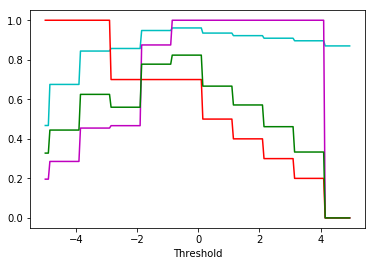

In [197]:
plt.plot(np.arange(-5, 5, 0.05), ts_acc, c = "c")
plt.plot(np.arange(-5, 5, 0.05), ts_precision, c = "m")
plt.plot(np.arange(-5, 5, 0.05), ts_recall, c = "red")
plt.plot(np.arange(-5, 5, 0.05), ts_f1, c = "green")
plt.xlabel('Threshold')
plt.show()

## Receiver Operating Characteristic (RoC) curve

Plot the RoC of your classifier.

In [198]:
result_score = test_set.apply(lambda row: naive_bayes_classifier(row, y_score = True), axis = 1)
fpr, tpr, thresholds = roc_curve(test_set["is_hk"].values.astype(int), result_score.values.astype(float))

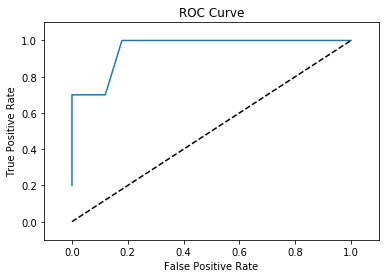

In [199]:
# plot ROC curve
plt.plot(fpr, tpr)
# random predictions curve
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

### Change the number of discretization bins from ∼1000 to ∼500. What happens to the RoC curve? Which discretization is better? 
The number of discretization bins can be considered as a hyperparameter, and must be chosen by comparing the final performance.

This part is in **`Housekeeping Genes Prediction – Part 2.ipynb`**

### Apply your best model on `unsup_train_set` to make class predictions.

In [200]:
result_on_unsup_train_set = unsup_train_set.apply(lambda row: naive_bayes_classifier(row), axis = 1)

In [210]:
result_on_unsup_train_set_df = result_on_unsup_train_set.to_frame(name = "is_hk")
result_on_unsup_train_set_df.head()

,is_hk
0,0
1,1
2,0
3,1
4,0


In [209]:
result_on_unsup_train_set_df.to_csv("prediction_with_index.csv", sep = ',', index = True)
result_on_unsup_train_set_df.to_csv("prediction_without_index.csv", sep = ',', index = False)